In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

import os
import csv
import numpy as np
import glob
import random

from sklearn.metrics import accuracy_score, f1_score

In [2]:
import csv
from tqdm import tqdm

label_dict = {}
with open("../ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]

def search_in_ground_truth(file_id: str, label_dict: dict) -> str:
    wav_name = file_id + ".wav"
    return label_dict.get(wav_name, None)

Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 3184363.48it/s]


In [3]:
def search_in_labels(filename, label_dict):
    base_name = os.path.splitext(filename)[0]
    
    if "_logmel" in base_name:
        base_name = base_name.replace("_logmel", "")
    if "_flipped" in base_name:
        base_name = base_name.replace("_flipped", "")
    
    parts = base_name.split("_")
    if len(parts) >= 2:
        audio_filename = f"{parts[0]}_{parts[1]}.wav"
    else:
        audio_filename = f"{base_name}.wav"
    
    return label_dict.get(audio_filename, None)

In [4]:
import pandas as pd
from tqdm import tqdm

def load_physical_features_as_df():
    df = pd.read_csv("../model/audio_features.csv", delimiter=",", encoding="utf-8")
    
    df_filtered = df[df['filename'].isin(label_dict.keys())]
    
    print(f"📊 Physical features loaded:")
    print(f"  Total rows in CSV: {len(df)}")
    print(f"  Filtered rows: {len(df_filtered)}")
    print(f"  Features: {list(df_filtered.columns)}")
    
    return df_filtered

physical_features_df = load_physical_features_as_df()

📊 Physical features loaded:
  Total rows in CSV: 28652
  Filtered rows: 19101
  Features: ['filename', 'split', 'duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'chroma_0_mean', 'chroma_0_std', 'chroma_1_mean', 'chroma_1_std', 'chroma_2_mean', 'chroma_2_std', 'chroma_3_mean', 'chroma_3_std', 'chroma_4_mean', 'chroma_4_std', 'chroma_5_mean', 'chroma_5_std', 'chroma_6_mean', 'chroma_6_std', 'chroma_7_mean', 'chroma_7_std', 'chroma_8_mean', 'chroma_8_std', 'chroma_9_mean', 'chroma_9_std', 'chroma_10_mean', 'chroma_10_std', 'chroma_11_mean', 'chroma_11_std', 'spectral_contrast_0_mean', 'spectral_contrast_0_std', 'spectral_contrast_1_mean', 'spectral_

In [5]:
from concurrent.futures import ThreadPoolExecutor
import glob
import os
import numpy as np

def load_single_acoustic_embedding(npy_file):
    basename = os.path.splitext(os.path.basename(npy_file))[0]  
    embedding = np.load(npy_file)
    return basename, embedding

def load_acoustic_embeddings(embedding_dir: str):
    npy_files = glob.glob(os.path.join(embedding_dir, "*.npy"))

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_single_acoustic_embedding, npy_files),
                            total=len(npy_files),
                            desc="Loading acoustic embeddings"))

    embedding_dict = dict(results)
    print(f"✅ Loaded {len(embedding_dict)} embeddings.")
    print(f"🧪 Sample shape: {next(iter(embedding_dict.values())).shape}")
    return embedding_dict

In [6]:
embedding_dir = "../model/embeddings_lhl/"
val_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "devel_files"))
test_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "test_files"))

Loading acoustic embeddings: 100%|██████████| 9596/9596 [00:01<00:00, 5679.25it/s]


✅ Loaded 9596 embeddings.
🧪 Sample shape: (3072,)


Loading acoustic embeddings: 100%|██████████| 9551/9551 [00:01<00:00, 5733.57it/s]

✅ Loaded 9551 embeddings.
🧪 Sample shape: (3072,)


In [7]:
def create_multimodal_features_with_merge(embeddings_dict, physical_features_df):    
    acoustic_data = []
    for file_id, embedding in embeddings_dict.items():
        filename = f"{file_id}.wav"
        
        acoustic_data.append({
            'filename': filename,
            'file_id': file_id,
            'embedding_idx': 0,
            'acoustic_features': embedding
        })
    
    acoustic_df = pd.DataFrame(acoustic_data)
    
    numeric_columns = physical_features_df.select_dtypes(include=[np.number]).columns.tolist()
    
    columns_to_remove = ['split'] 
    for col in columns_to_remove:
        if col in numeric_columns:
            numeric_columns.remove(col)
            print(f"⚠️  Removed column: {col}")
    
    physical_subset = physical_features_df[['filename'] + numeric_columns].copy()
    
    merged_df = acoustic_df.merge(physical_subset, on='filename', how='left')
    
    merged_df[numeric_columns] = merged_df[numeric_columns].fillna(0)
    
    combined_features = {}
    
    for _, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Creating combined features"):
        file_id = row['file_id']
        embedding_idx = row['embedding_idx']
        
        acoustic = row['acoustic_features']
        physical = row[numeric_columns].values.astype(np.float32)
        combined = np.concatenate([acoustic, physical])
        
        if file_id not in combined_features:
            combined_features[file_id] = []
        combined_features[file_id].append(combined)
    
    for file_id in combined_features:
        if len(combined_features[file_id]) == 1:
            combined_features[file_id] = combined_features[file_id][0]
    
    print(f"📊 Multimodal features created:")
    print(f"  Files: {len(combined_features)}")
    print(f"  Acoustic features: {acoustic.shape[0]}")
    print(f"  Physical features: {len(numeric_columns)}")
    print(f"  Combined dimension: {combined.shape[0]}")
    print(f"  Used physical columns: {numeric_columns[:10]}...")  
    return combined_features

test_multimodal = create_multimodal_features_with_merge(test_embeddings_dict, physical_features_df)
val_multimodal = create_multimodal_features_with_merge(val_embeddings_dict, physical_features_df)

Creating combined features: 100%|██████████| 9551/9551 [00:02<00:00, 3954.02it/s]


📊 Multimodal features created:
  Files: 9551
  Acoustic features: 3072
  Physical features: 75
  Combined dimension: 3147
  Used physical columns: ['duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean']...


Creating combined features: 100%|██████████| 9596/9596 [00:02<00:00, 4059.14it/s]

📊 Multimodal features created:
  Files: 9596
  Acoustic features: 3072
  Physical features: 75
  Combined dimension: 3147
  Used physical columns: ['duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean']...


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveEmbeddingExtractor(nn.Module):
    def __init__(self, input_dim=3072, projection_dim=256, hidden_dim=512):
        super(ContrastiveEmbeddingExtractor, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim),
            L2Norm(dim=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    
    def forward(self, x, return_features=False):
        features = self.encoder(x)
        
        logits = self.classifier(features)
        
        if return_features:
            projections = self.projection_head(features)
            return logits.squeeze(), projections, features
        else:
            return logits.squeeze()

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim)
    
class SupervisedContrastiveLoss(nn.Module):

    def __init__(self, temperature=0.05, minority_weight=2.0):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.minority_weight = minority_weight
        
    def forward(self, projections, labels):
        device = projections.device
        batch_size = projections.shape[0]
        
        similarity_matrix = torch.matmul(projections, projections.T) / self.temperature
        
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        mask = mask - torch.eye(batch_size).to(device)
        
        exp_sim = torch.exp(similarity_matrix)
        
        pos_sim = exp_sim * mask
        
        neg_mask = torch.ones_like(mask) - torch.eye(batch_size).to(device)
        all_sim = exp_sim * neg_mask
        
        losses = []
        for i in range(batch_size):
            if mask[i].sum() > 0:  
                pos_sum = pos_sim[i].sum()
                neg_sum = all_sim[i].sum()
                
                if neg_sum > 0:
                    loss_i = -torch.log(pos_sum / neg_sum)
                    
                    if labels[i] == 1:  
                        loss_i = loss_i * self.minority_weight
                    
                    losses.append(loss_i)
        
        if len(losses) > 0:
            return torch.stack(losses).mean()
        else:
            return torch.tensor(0.0).to(device)

class CombinedLoss(nn.Module):
    def __init__(self, classification_loss, contrastive_loss, alpha=0.3):
        super(CombinedLoss, self).__init__()
        self.classification_loss = classification_loss
        self.contrastive_loss = contrastive_loss
        self.alpha = alpha  
        
    def forward(self, logits, projections, labels):
        cls_loss = self.classification_loss(logits, labels.float())
        
        cont_loss = self.contrastive_loss(projections, labels)
        
        total_loss = (1 - self.alpha) * cls_loss + self.alpha * cont_loss
        
        return total_loss, cls_loss, cont_loss

In [9]:
from torch.utils.data import Dataset
import torch
import random

class ColdDetectionDataset(Dataset):
    def __init__(self,
                 embedding_dict: dict,
                 label_dict: dict,
                 label_ratio = 2,
                ):
        
        self.data_map = {} 
        self.all_samples = []
        
        for file_id, emb in embedding_dict.items():
            label_key = f"{file_id}.wav"
            if label_key not in label_dict:
                continue
                
            raw_label = label_dict[label_key]
            lab = 1 if raw_label == "C" else 0
            
            sample = (
                file_id,
                torch.tensor(emb, dtype=torch.float32),
                torch.tensor(lab, dtype=torch.long),
            ) 
            self.all_samples.append(sample)
        
        self.create_balanced_cold_dataset( label_ratio)

        
    
    def create_balanced_cold_dataset(self, label_ratio):
        samples_by_label = {0: [], 1: []}
        for sample in self.all_samples:
            label = sample[2].item()
            samples_by_label[label].append(sample)
                        
        num_healthy_samples = min(len(samples_by_label[1])*label_ratio, len(samples_by_label[0]))     
        self.balanced_samples = []
        
        for sample in samples_by_label[1]:
            self.balanced_samples.append(sample)
        
        healthy_samples = random.sample(samples_by_label[0], num_healthy_samples)
        self.balanced_samples.extend(healthy_samples)

        random.shuffle(self.balanced_samples)
        self.epoch_samples = self.balanced_samples.copy()

    def __getitem__(self, idx):
        sample = self.epoch_samples[idx]
        
        if len(sample) == 3:
            file_id, embedding, label = sample
            return embedding, label
        else:
            raise ValueError(f"Unexpected sample format with {len(sample)} elements")
        
    
    def __len__(self):
        return len(self.epoch_samples)
    
    
    def refresh_epoch_samples_balanced(self, label_ratio):
        self.create_balanced_cold_dataset(label_ratio)
    
    def get_statistics(self):
        stats = {
            'total_samples': len(self.all_samples),
            'epoch_samples': len(self.epoch_samples),
        }
        
        return stats

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load weights from the pretrained model
model = ContrastiveEmbeddingExtractor(input_dim=3147, projection_dim=1024, hidden_dim=512).to(device)
pretrained_model_path = "../model/best_contrastive_fusion_concat.pth"
model.load_state_dict(torch.load(pretrained_model_path))
model

ContrastiveEmbeddingExtractor(
  (encoder): Sequential(
    (0): Linear(in_features=3147, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): L2Norm()
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [11]:
devel_dataset = ColdDetectionDataset(
    val_multimodal,
    label_dict,
    label_ratio=15,
)
devel_loader = DataLoader(devel_dataset, batch_size=128, shuffle=False)

In [12]:
import numpy as np
from sklearn.metrics import f1_score, recall_score

probs = []   
labels = []

model.eval()
with torch.no_grad():
    for X, y in devel_loader:
        logits = model(X.to(device)).squeeze()
        p = torch.sigmoid(logits).cpu().numpy()
        probs.extend(p)
        labels.extend(y.numpy())

probs = np.array(probs)
labels = np.array(labels)

best_t, best_uar = 0.5, 0
best_f1 = 0

print("🎯 Threshold optimization using UAR:")
print("-" * 50)

for t in np.linspace(0.1, 0.9, 81):
    preds = (probs > t).astype(int)
    
    uar = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds)
    
    if uar > best_uar:
        best_uar = uar
        best_t = t
        best_f1 = f1

print(f"🏆 Best Threshold = {best_t:.2f}")
print(f"📊 UAR = {best_uar:.3f}")

🎯 Threshold optimization using UAR:
--------------------------------------------------
🏆 Best Threshold = 0.39
📊 UAR = 0.616


In [13]:
test_loader = DataLoader(devel_dataset, batch_size=128, shuffle=False)

test_preds = []
test_labels = []

threshold = best_t

with torch.no_grad():
    with tqdm(total=len(test_loader.dataset),
              desc="Testing",
              unit="samples",
              ncols=100) as progress_bar:
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze() 
            probs = torch.sigmoid(logits)
            preds = (probs > 0.6).long()

            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(batch_y.cpu().tolist())

            progress_bar.update(batch_X.size(0))

Testing: 100%|██████████████████████████████████████████| 9596/9596 [00:00<00:00, 91302.97samples/s]


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score

uar = recall_score(test_labels, test_preds, average='macro')

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   F1 Score: {f1:.4f}")
print(f"   UAR (Unweighted Average Recall): {uar:.4f}")

if len(set(test_labels)) > 1 and len(set(test_preds)) > 1:
    cm = confusion_matrix(test_labels, test_preds)
    
    class_recalls = []
    for i in range(len(cm)):
        if cm[i].sum() > 0:  
            recall = cm[i, i] / cm[i].sum()
            class_recalls.append(recall)
        else:
            class_recalls.append(0.0)
    
    print(f"\n🎯 PER-CLASS RECALL:")
    class_names = ['Healthy', 'Cold']
    for i, (name, recall) in enumerate(zip(class_names, class_recalls)):
        print(f"   Class {i} ({name}): {recall:.4f}")
    
    manual_uar = np.mean(class_recalls)
    print(f"\n✅ UAR Verification:")
    print(f"   sklearn UAR: {uar:.4f}")
    print(f"   Manual UAR:  {manual_uar:.4f}")
    print(f"   Match: {'✓' if abs(uar - manual_uar) < 0.0001 else '✗'}")


📈 PERFORMANCE METRICS:
   F1 Score: 0.1988
   UAR (Unweighted Average Recall): 0.5913

🎯 PER-CLASS RECALL:
   Class 0 (Healthy): 0.9264
   Class 1 (Cold): 0.2562

✅ UAR Verification:
   sklearn UAR: 0.5913
   Manual UAR:  0.5913
   Match: ✓


🎨 Creating fancy visualizations...


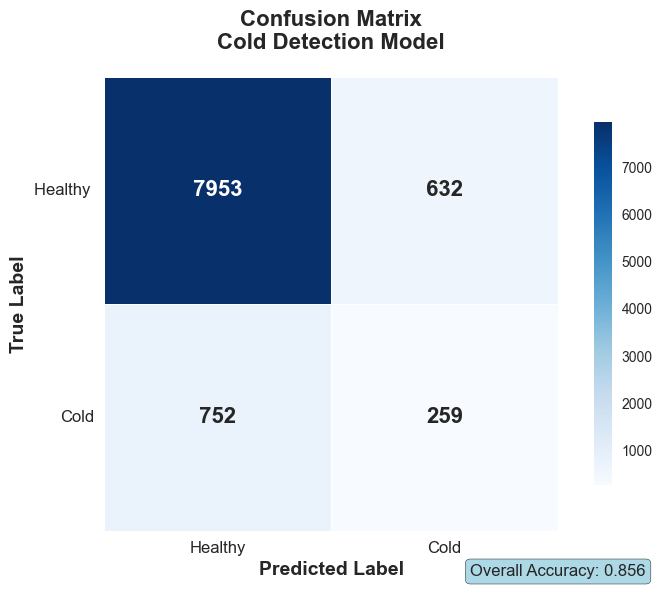

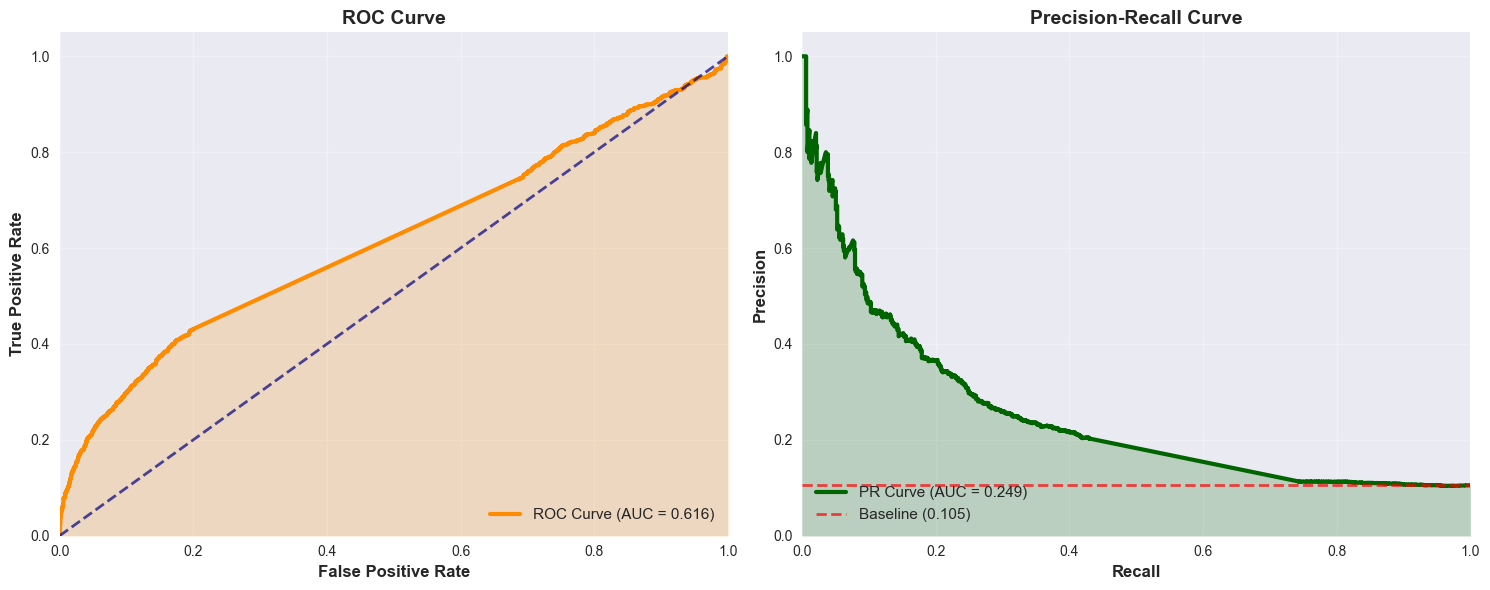

C:\Users\10857\AppData\Local\Temp\ipykernel_24488\2191437364.py:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(data_for_box, labels=['Healthy', 'Cold '],


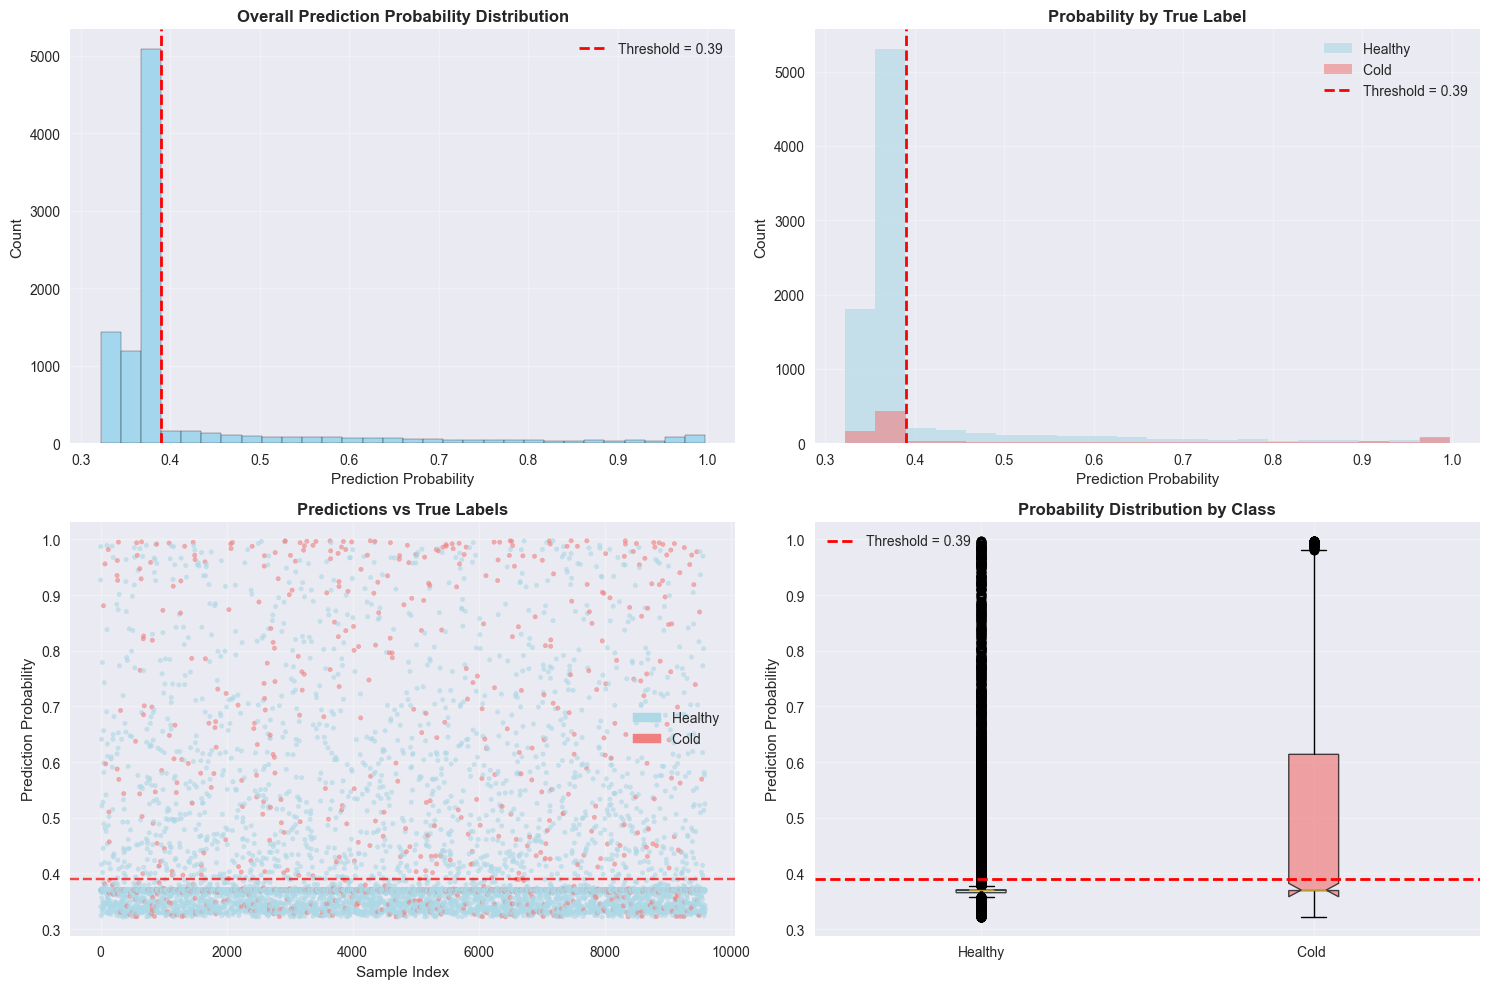

✨ All visualizations created successfully!


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_confusion_matrix_fancy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8},
                annot_kws={'size': 16, 'weight': 'bold'})
    
    ax.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=14, fontweight='bold')
    ax.set_title('Confusion Matrix\nCold Detection Model', 
                 fontsize=16, fontweight='bold', pad=20)
    
    ax.set_xticklabels(['Healthy', 'Cold'], fontsize=12)
    ax.set_yticklabels(['Healthy ', 'Cold'], fontsize=12, rotation=0)
    
    total = cm.sum()
    accuracy = (cm[0,0] + cm[1,1]) / total
    ax.text(1, -0.1, f'Overall Accuracy: {accuracy:.3f}', 
            transform=ax.transAxes, ha='center', fontsize=12, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.tight_layout()
    return fig

def plot_roc_pr_curves(y_true, y_probs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=3, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.7)
    ax1.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)
    
    ax2.plot(recall, precision, color='darkgreen', lw=3,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax2.fill_between(recall, precision, alpha=0.2, color='darkgreen')
    
    baseline = np.sum(y_true) / len(y_true)
    ax2.axhline(y=baseline, color='red', linestyle='--', lw=2, alpha=0.7,
                label=f'Baseline ({baseline:.3f})')
    
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left", fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_prediction_distribution(y_true, y_probs, threshold=0.5):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    healthy_probs = y_probs[y_true == 0]
    cold_probs = y_probs[y_true == 1]
    
    ax1.hist(y_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(threshold, color='red', linestyle='--', lw=2, label=f'Threshold = {threshold:.2f}')
    ax1.set_title('Overall Prediction Probability Distribution', fontweight='bold')
    ax1.set_xlabel('Prediction Probability')
    ax1.set_ylabel('Count')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy ', color='lightblue')
    ax2.hist(cold_probs, bins=20, alpha=0.6, label='Cold ', color='lightcoral')
    ax2.axvline(threshold, color='red', linestyle='--', lw=2, label=f'Threshold = {threshold:.2f}')
    ax2.set_title('Probability by True Label', fontweight='bold')
    ax2.set_xlabel('Prediction Probability')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    colors = ['lightblue' if label == 0 else 'lightcoral' for label in y_true]
    ax3.scatter(range(len(y_probs)), y_probs, c=colors, alpha=0.6, s=10)
    ax3.axhline(threshold, color='red', linestyle='--', alpha=0.7)
    ax3.set_title('Predictions vs True Labels', fontweight='bold')
    ax3.set_xlabel('Sample Index')
    ax3.set_ylabel('Prediction Probability')
    
    import matplotlib.patches as mpatches
    healthy_patch = mpatches.Patch(color='lightblue', label='Healthy ')
    cold_patch = mpatches.Patch(color='lightcoral', label='Cold ')
    ax3.legend(handles=[healthy_patch, cold_patch])
    ax3.grid(True, alpha=0.3)
    
    data_for_box = [healthy_probs, cold_probs]
    box_plot = ax4.boxplot(data_for_box, labels=['Healthy', 'Cold '], 
                          patch_artist=True, notch=True)
    
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.axhline(threshold, color='red', linestyle='--', lw=2, label=f'Threshold = {threshold:.2f}')
    ax4.set_title('Probability Distribution by Class', fontweight='bold')
    ax4.set_ylabel('Prediction Probability')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

print("🎨 Creating fancy visualizations...")

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        logits = model(X.to(device)).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

fig1 = plot_confusion_matrix_fancy(test_labels, test_preds)
plt.show()

fig2 = plot_roc_pr_curves(all_labels, all_probs)
plt.show()

fig3 = plot_prediction_distribution(all_labels, all_probs, threshold=best_t)
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
accuracy = accuracy_score(test_labels, test_preds)
uar = recall_score(test_labels, test_preds, average='macro')

metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Accuracy': accuracy,
    'UAR': uar
}


print("✨ All visualizations created successfully!")